In [5]:
%pip install pandas wordcloud nltk textblob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
nltk.download('stopwords')
nltk.download('punkt')

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohamed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mohamed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# write the directory for the dataset
data_directory = 'SupremeCourtEDAFinal.csv'
df = pd.read_csv(data_directory, usecols=lambda x: x != 'Unnamed: 0')

In [7]:
stop_words = set(stopwords.words('english'))

# OPTIONAL: you may add more stop words if you feel like it 
# (just let me know so that we are on the same page)
custom_stopwords = stop_words.union({'senator', 'judge', 'judges', 'chairman', 'justice', 'supreme', 'court', 'mr'})

# INFO: this represents the top 20 words with the highest differences in tf-idx scores
def plot_top_words(dataset1, dataset2, dataset1_label, dataset2_label, datassave_path=None):
    dataset1=dataset1['speaker_statement']
    dataset2=dataset2['speaker_statement']
    combined_data = pd.concat([dataset1, dataset2])
    dataset1 = dataset1.astype(str)
    dataset2 = dataset2.astype(str)
    combined_data_tokens = combined_data.apply(lambda x: ' '.join([word for word in word_tokenize(str(x)) if isinstance(word, str) and word.lower() not in custom_stopwords]))
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_data_tokens)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_matrix1 = tfidf_matrix[:len(dataset1)]
    tfidf_matrix2 = tfidf_matrix[len(dataset1):]
    tfidf_scores1 = np.asarray(tfidf_matrix1.mean(axis=0)).reshape(-1)
    tfidf_scores2 = np.asarray(tfidf_matrix2.mean(axis=0)).reshape(-1)
    tfidf_diff = tfidf_scores1 - tfidf_scores2
    top_indices = np.argsort(tfidf_diff)[-20:]
    top_words = [feature_names[i] for i in top_indices]
    top_diff_scores = [tfidf_diff[i] for i in top_indices]
    plt.figure(figsize=(10, 8))
    plt.barh(top_words, top_diff_scores, color='skyblue')
    plt.xlabel('Difference in TF-IDF Score')
    plt.title('Top 20 Words with Highest Difference in TF-IDF Score (' + dataset1_label + ' - ' + dataset2_label + ')')
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()

# INFO: this will produce a side-by-side sentiment analysis of each dataset
def plot_sentiment_analysis(dataset1, dataset2, dataset1_label, dataset2_label):
    dataset1=dataset1['speaker_statement']
    dataset2=dataset2['speaker_statement']
    dataset1_sentiments = dataset1.apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None)
    dataset2_sentiments = dataset2.apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(dataset1_sentiments, bins=20, color='skyblue', alpha=0.7)
    plt.title('Sentiment Distribution - ' + dataset1_label)
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency')
    plt.yticks(np.arange(0, 15001, 3000))  # Fixing y-axis ticks to 0, 3000, 6000, 9000, 12000, 15000
    plt.subplot(1, 2, 2)
    plt.hist(dataset2_sentiments, bins=20, color='salmon', alpha=0.7)
    plt.title('Sentiment Distribution - ' + dataset2_label)
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency')
    plt.yticks(np.arange(0, 15001, 3000))  # Fixing y-axis ticks to 0, 3000, 6000, 9000, 12000, 15000
    plt.show()

# INFO: this will produce one plot showing the difference in sentiment between each dataset
def plot_sentiment_difference(dataset1, dataset2, dataset1_label, dataset2_label):
    dataset1=dataset1['speaker_statement']
    dataset2=dataset2['speaker_statement']
    dataset1_sentiments = dataset1.apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None)
    dataset2_sentiments = dataset2.apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None)
    sentiment_difference = dataset1_sentiments - dataset2_sentiments
    sentiment_difference = dataset1_sentiments.sub(dataset2_sentiments, fill_value=0)
    plt.figure(figsize=(8, 6))
    plt.hist(sentiment_difference, bins=20, color='purple', alpha=0.7)
    plt.title('Difference in Sentiment Polarity (' + dataset1_label + ' - ' + dataset2_label + ')')
    plt.xlabel('Sentiment Polarity Difference')
    plt.ylabel('Frequency')
    plt.show()

# INFO: helper function for the below function
def color_func(word, **kwargs):
    score = TextBlob(word).sentiment.polarity
    if score > 0:
        return "hsl(150, 100%, 30%)"  
    else:
        return "hsl(0, 100%, 50%)" 

# INFO: this will remove the stop words then calculate the tf-idf score
# for each word (the higher the score, the more important the word is)
# and then compare the tf-idf of that word with the opposing dataset.
# The higher the difference, the larger it will appear on the word count.
# Therefore, this represents the words used by one party over the other.
# It will also produce a word cloud with only sentimental words (aka with non-zero 
# sentiment value) and will display positive words in green and negative words in red.
def plot_wordclouds_sentimental(dataset1, dataset2, dataset1_label, dataset2_label):
    dataset1 = dataset1['speaker_statement'].astype(str)
    dataset2 = dataset2['speaker_statement'].astype(str)
    combined_data = pd.concat([dataset1, dataset2])
    combined_data_tokens = combined_data.apply(
        lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in custom_stopwords])
    )
    def filter_by_sentiment(text):
        return ' '.join([word for word in word_tokenize(text) if TextBlob(word).sentiment.polarity != 0])
    combined_data_tokens = combined_data_tokens.apply(filter_by_sentiment)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_data_tokens)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_matrix1 = tfidf_matrix[:len(dataset1)]
    tfidf_matrix2 = tfidf_matrix[len(dataset1):]
    tfidf_scores1 = np.asarray(tfidf_matrix1.mean(axis=0)).reshape(-1)
    tfidf_scores2 = np.asarray(tfidf_matrix2.mean(axis=0)).reshape(-1)
    tfidf_diff = tfidf_scores1 - tfidf_scores2
    wordcloud1_data = {word: tfidf_scores1[i] for i, word in enumerate(feature_names) if tfidf_diff[i] > 0}
    wordcloud2_data = {word: tfidf_scores2[i] for i, word in enumerate(feature_names) if tfidf_diff[i] < 0}
    wordcloud1 = WordCloud(width=400, height=400, background_color='white',
                           color_func=lambda *args, **kwargs: color_func(*args, **kwargs)).generate_from_frequencies(wordcloud1_data)
    wordcloud2 = WordCloud(width=400, height=400, background_color='white',
                           color_func=lambda *args, **kwargs: color_func(*args, **kwargs)).generate_from_frequencies(wordcloud2_data)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud1, interpolation='bilinear')
    plt.title('Sentimental Word Cloud - ' + dataset1_label)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud2, interpolation='bilinear')
    plt.title('Sentimental Word Cloud - ' + dataset2_label)
    plt.axis('off')
    plt.show()

#Supreme Court Nominees nominated by a Republican President from 1971 - 2018
supreme_court_reps = [
    {"name": "Brett M. Kavanaugh", "year": 2018, "nominated_by": "Donald Trump", "party": "R"},
    {"name": "Neil M. Gorsuch", "year": 2017, "nominated_by": "Donald Trump", "party": "R"},
    {"name": "Samuel A. Alito, Jr.", "year": 2006, "nominated_by": "George W. Bush", "party": "R"},
    {"name": "John G. Roberts, Jr.", "year": 2005, "nominated_by": "George W. Bush", "party": "R"},
    {"name": "Clarence Thomas", "year": 1991, "nominated_by": "George H. W. Bush", "party": "R"},
    {"name": "David H. Souter", "year": 1990, "nominated_by": "George H. W. Bush", "party": "R"},
    {"name": "Anthony M. Kennedy", "year": 1988, "nominated_by": "Ronald Reagan", "party": "R"},
    {"name": "Robert Bork", "year": 1987, "nominated_by": "Ronald Reagan", "party": "R"},
    {"name": "Antonin Scalia", "year": 1986, "nominated_by": "Ronald Reagan", "party": "R"},
    {"name": "William H. Rehnquist (to be Chief Justice)", "year": 1986, "nominated_by": "Ronald Reagan", "party": "R"},
    {"name": "Sandra Day O'Connor", "year": 1981, "nominated_by": "Ronald Reagan", "party": "R"},
    {"name": "John Paul Stevens", "year": 1975, "nominated_by": "Gerald Ford", "party": "R"},
    {"name": "William H. Rehnquist (to be Associate Justice) and Lewis F. Powell Jr.", "year": 1971, "nominated_by": "Richard Nixon", "party": "R"},
]
#Supreme Court Nominees nominated by a Democratic President from 1971 - 2018
supreme_court_dems = [
    {"name": "Elena Kagan", "year": 2010, "nominated_by": "Barack Obama", "party": "D"},
    {"name": "Sonia Sotomayor", "year": 2009, "nominated_by": "Barack Obama", "party": "D"},
    {"name": "Stephen G. Breyer", "year": 1994, "nominated_by": "Bill Clinton", "party": "D"},
    {"name": "Ruth Bader Ginsburg", "year": 1993, "nominated_by": "Bill Clinton", "party": "D"},
    ]

rep_nominees_df = pd.DataFrame(supreme_court_reps)
dem_nominees_df = pd.DataFrame(supreme_court_dems)

#Republican Speaker Statements
dfRepublicans = df[df["speaker_party"] == "R"]
#Democrat Speaker Statements
dfDems = df[df["speaker_party"] == "D"]
#republican nominees
rep_df = df[df['nominee'].isin(rep_nominees_df['name'])]
#democratic nominees
dem_df = df[df['nominee'].isin(dem_nominees_df['name'])]

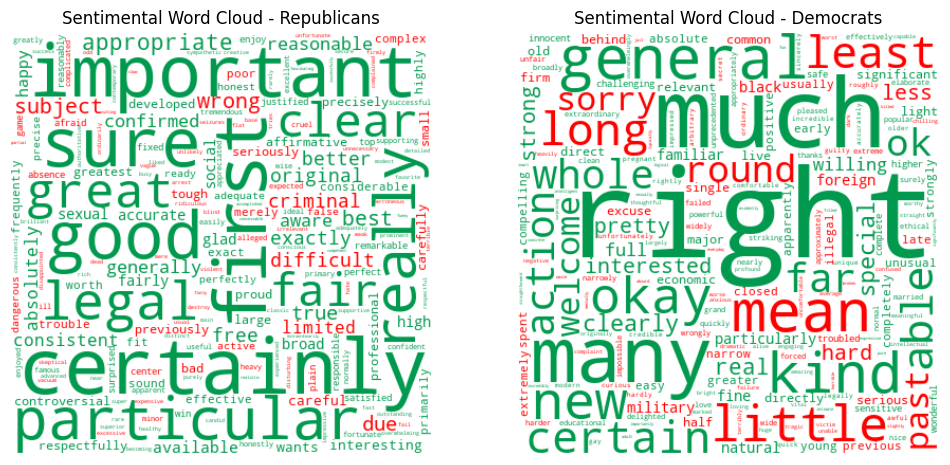

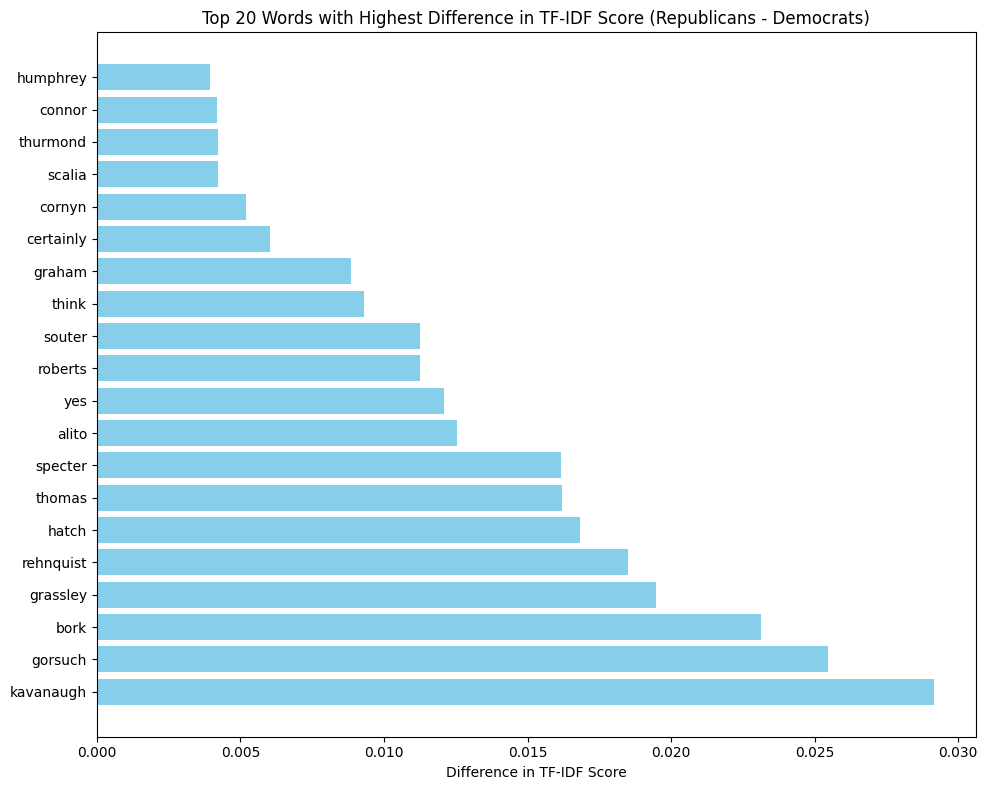

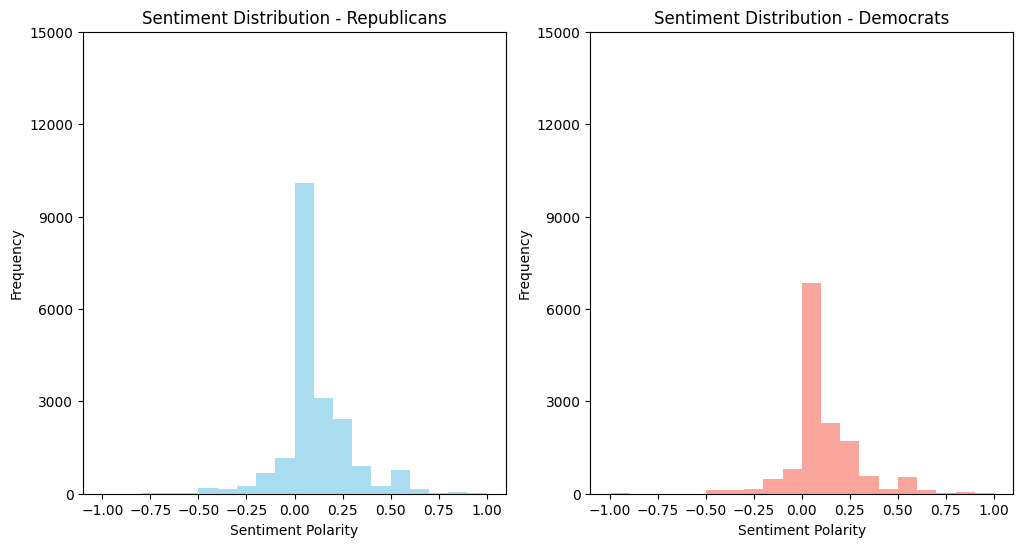

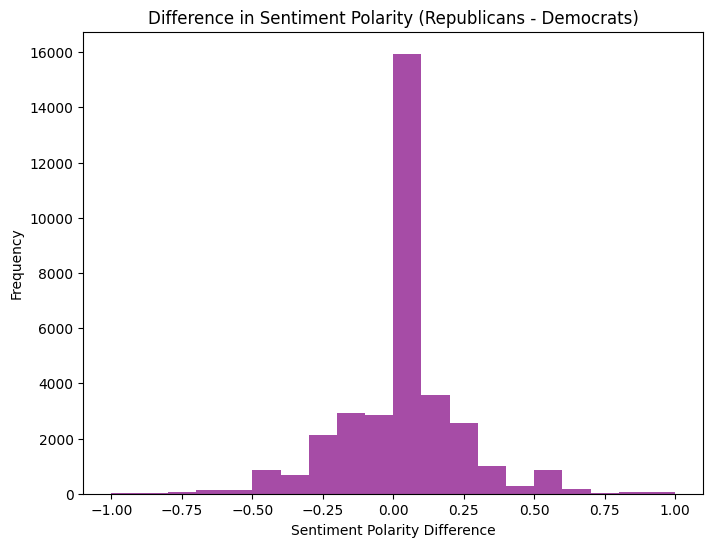

In [8]:
# INVESTIGATE: Republicans versus Democrats 

# do the data filtering so that they are split into two datasets. 
dataset1 = df[df["speaker_party"] == "R"]
dataset2 = df[df["speaker_party"] == "D"]

# describe your dataset here, this will be the description used on plots
dataset1_label = "Republicans"
dataset2_label = "Democrats"

# EDA
plot_wordclouds_sentimental(dataset1, dataset2, dataset1_label, dataset2_label)
plot_top_words(dataset1, dataset2, dataset1_label, dataset2_label)
plot_sentiment_analysis(dataset1, dataset2, dataset1_label, dataset2_label)
plot_sentiment_difference(dataset1, dataset2, dataset1_label, dataset2_label)

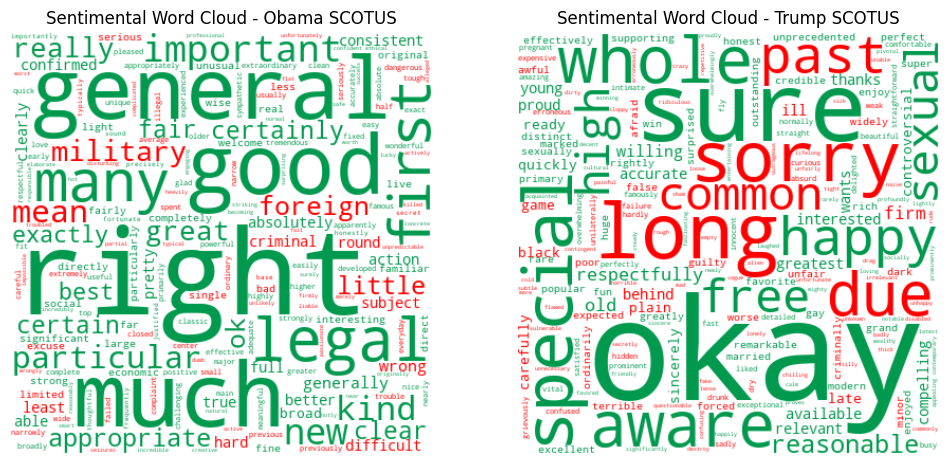

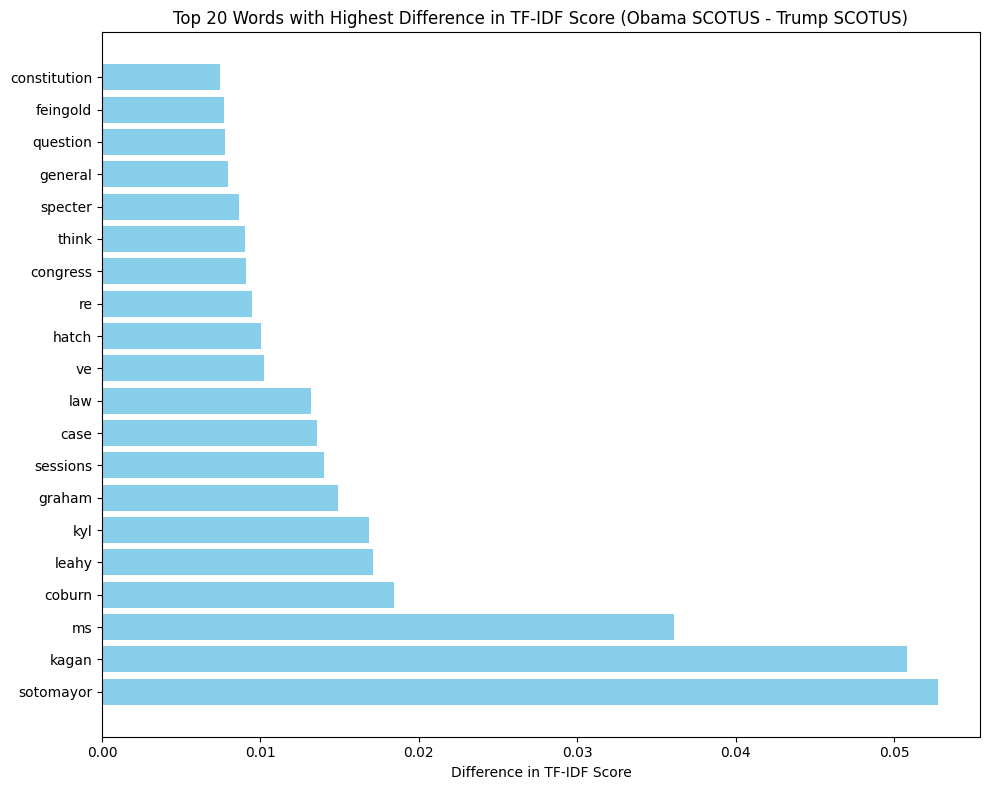

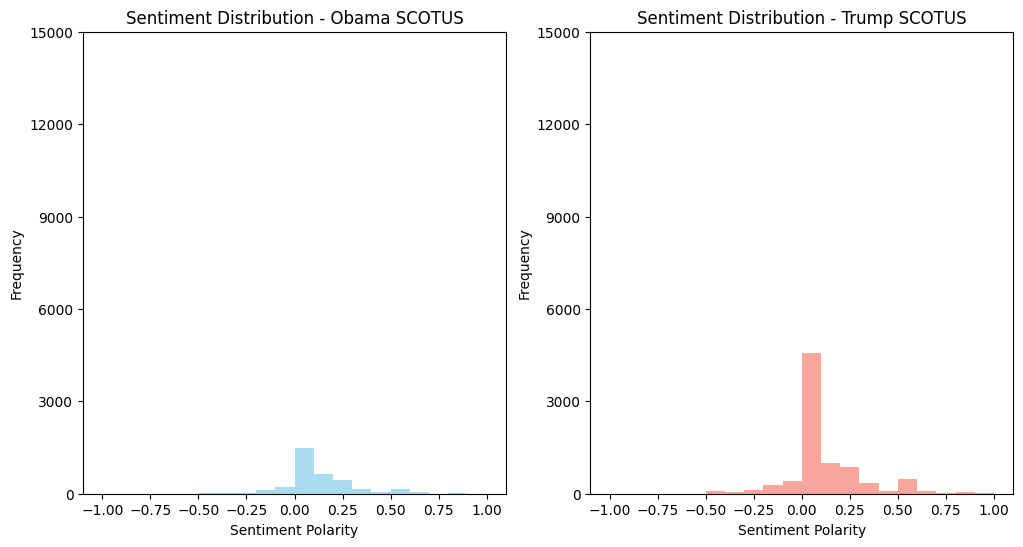

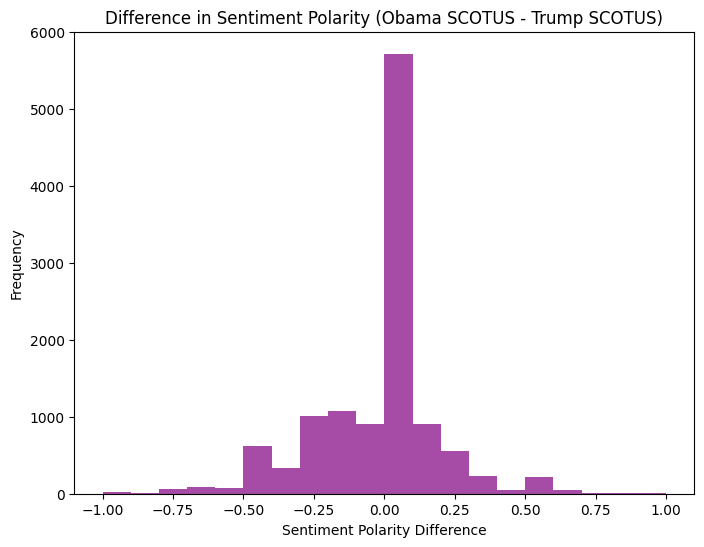

In [9]:
# INVESTIGATE: Obama SCOTUS versus Trump SCOTUS
dataset1 = df[(df["Year"] == 2009) | (df["Year"] == 2010)]
dataset2 = df[(df["Year"] == 2018) | (df["Year"] == 2017)]

# describe your dataset here, this will be the description used on plots
dataset1_label = "Obama SCOTUS"
dataset2_label = "Trump SCOTUS"

## EDA
plot_wordclouds_sentimental(dataset1, dataset2, dataset1_label, dataset2_label)
plot_top_words(dataset1, dataset2, dataset1_label, dataset2_label)
plot_sentiment_analysis(dataset1, dataset2, dataset1_label, dataset2_label)
plot_sentiment_difference(dataset1, dataset2, dataset1_label, dataset2_label)

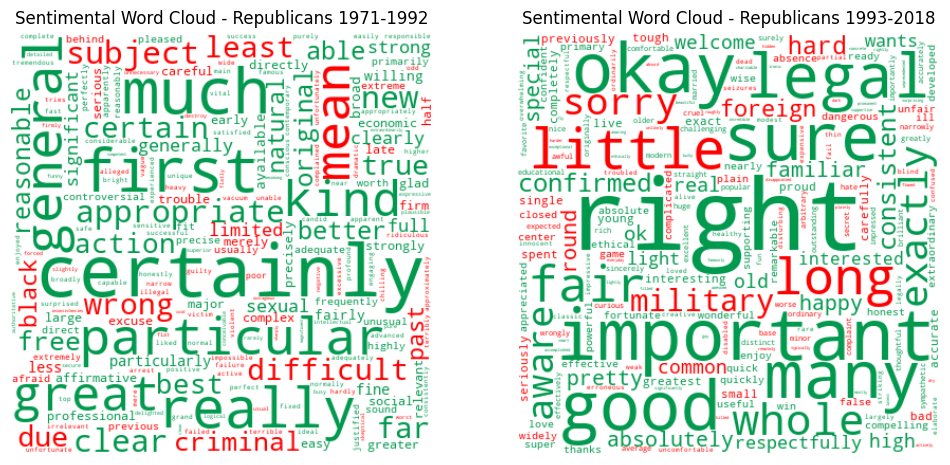

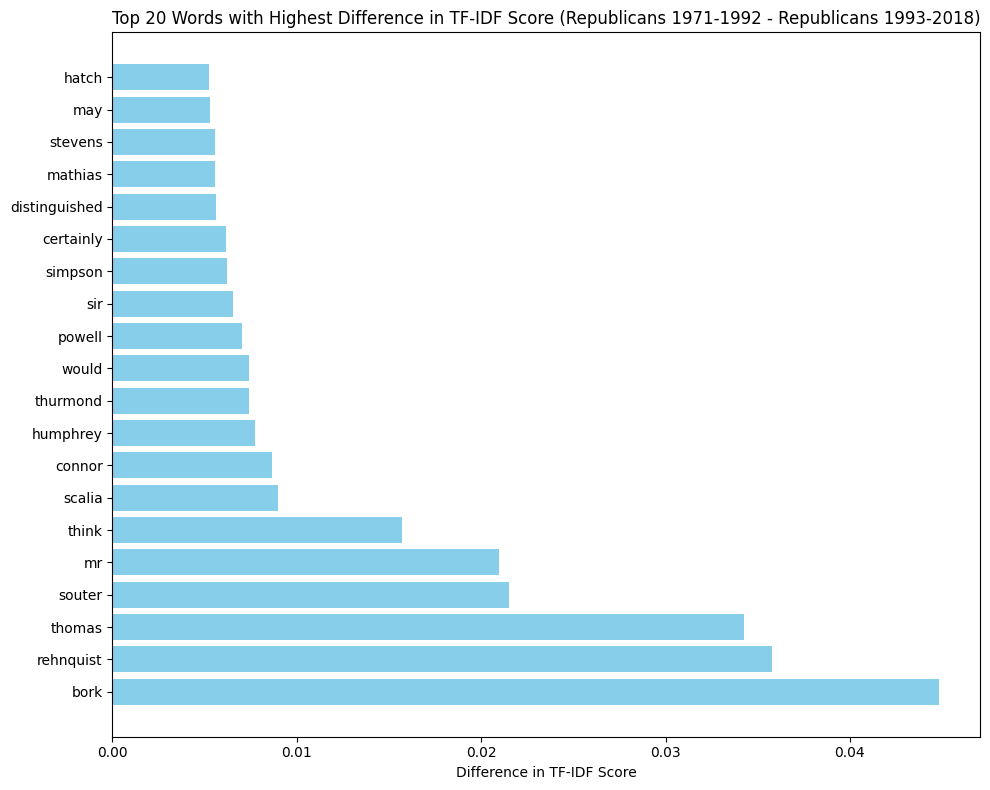

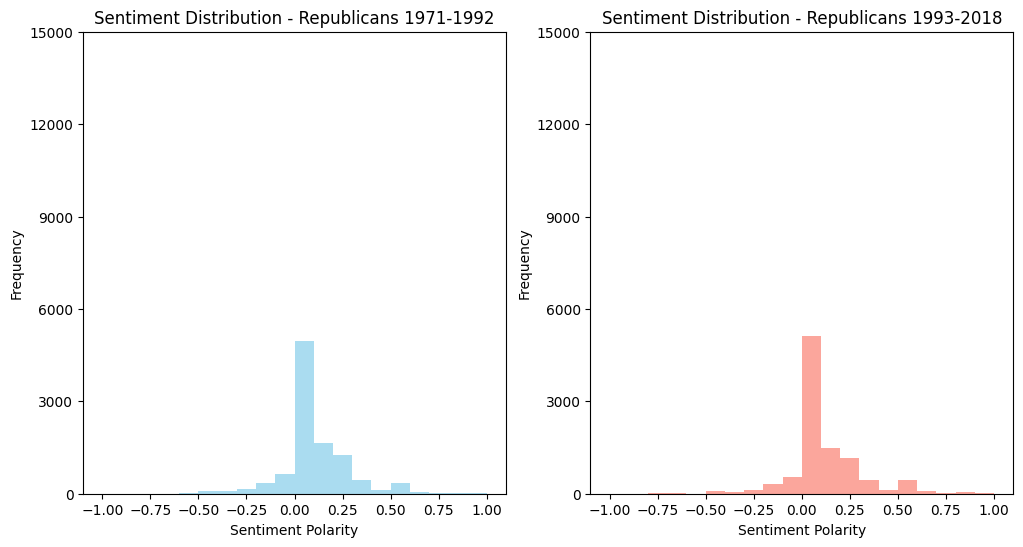

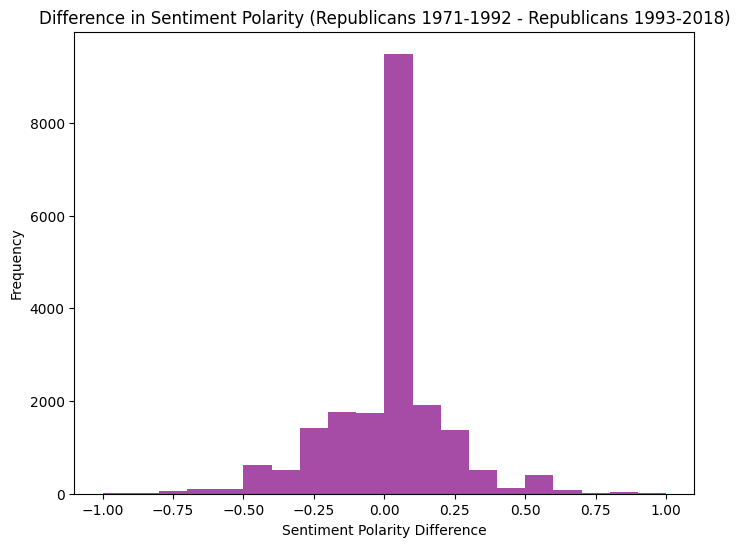

In [10]:
# INVESTIGATE: Republican questions pre- and post- 1992
dataset1 = dfRepublicans[dfRepublicans["Year"] <= 1992]
dataset2 = dfRepublicans[dfRepublicans["Year"] > 1992]

# describe your dataset here, this will be the description used on plots
dataset1_label = "Republicans 1971-1992"
dataset2_label = "Republicans 1993-2018"

# EDA 
plot_wordclouds_sentimental(dataset1, dataset2, dataset1_label, dataset2_label)
plot_top_words(dataset1, dataset2, dataset1_label, dataset2_label)
plot_sentiment_analysis(dataset1, dataset2, dataset1_label, dataset2_label)
plot_sentiment_difference(dataset1, dataset2, dataset1_label, dataset2_label)

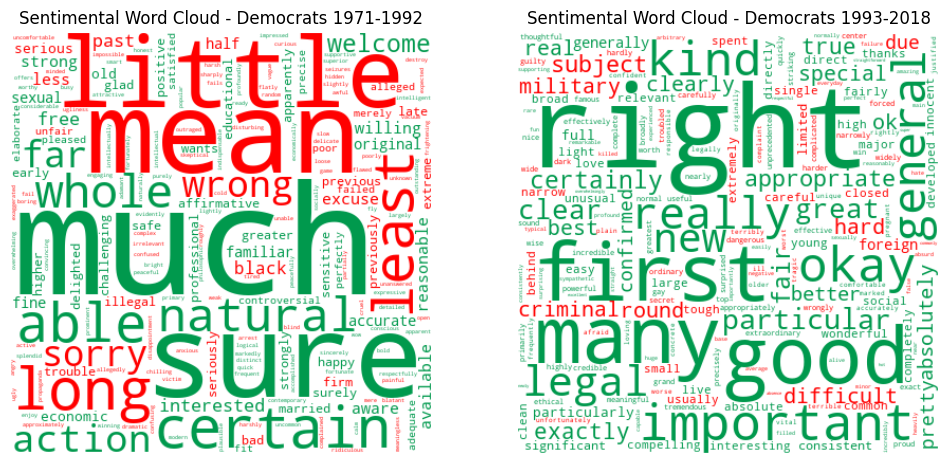

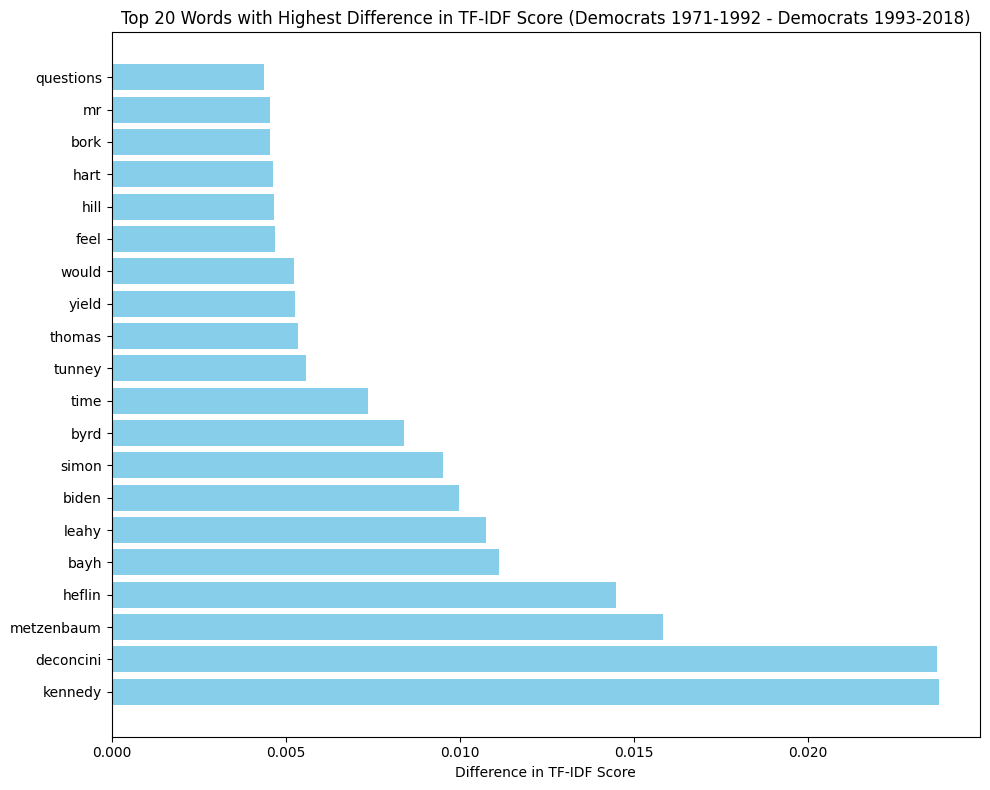

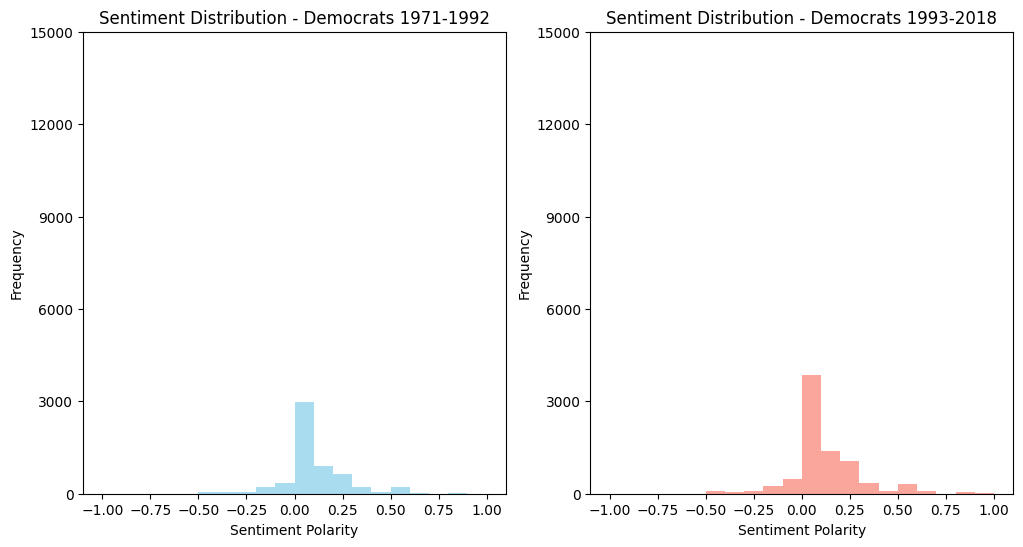

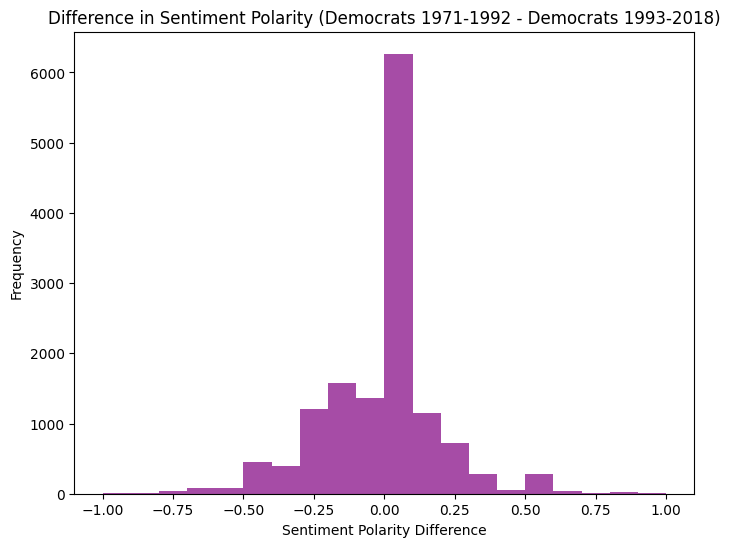

In [11]:
# INVESTIGATE: Democrat question pre- and post- 1992
dataset1 = dfDems[dfDems["Year"] <= 1992]
dataset2 = dfDems[dfDems["Year"] > 1992]

# describe your dataset here, this will be the description used on plots
dataset1_label = "Democrats 1971-1992"
dataset2_label = "Democrats 1993-2018"

# EDA 
plot_wordclouds_sentimental(dataset1, dataset2, dataset1_label, dataset2_label)
plot_top_words(dataset1, dataset2, dataset1_label, dataset2_label)
plot_sentiment_analysis(dataset1, dataset2, dataset1_label, dataset2_label)
plot_sentiment_difference(dataset1, dataset2, dataset1_label, dataset2_label)

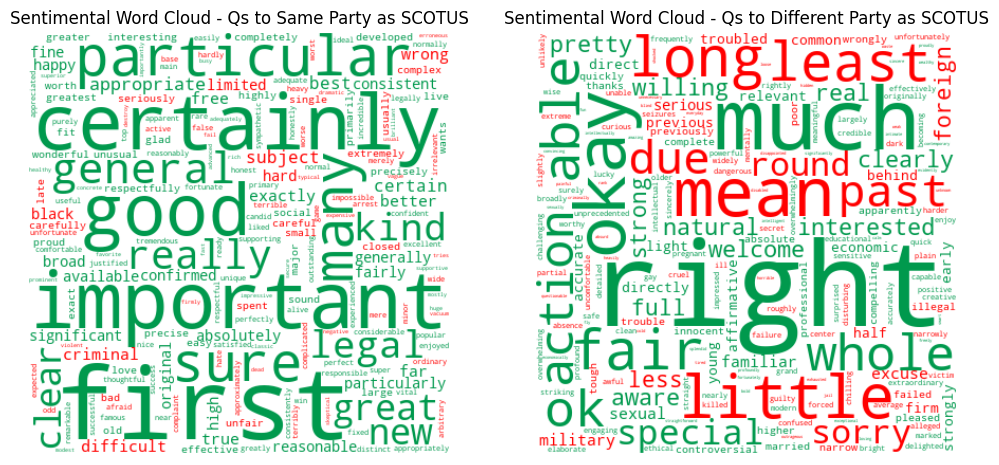

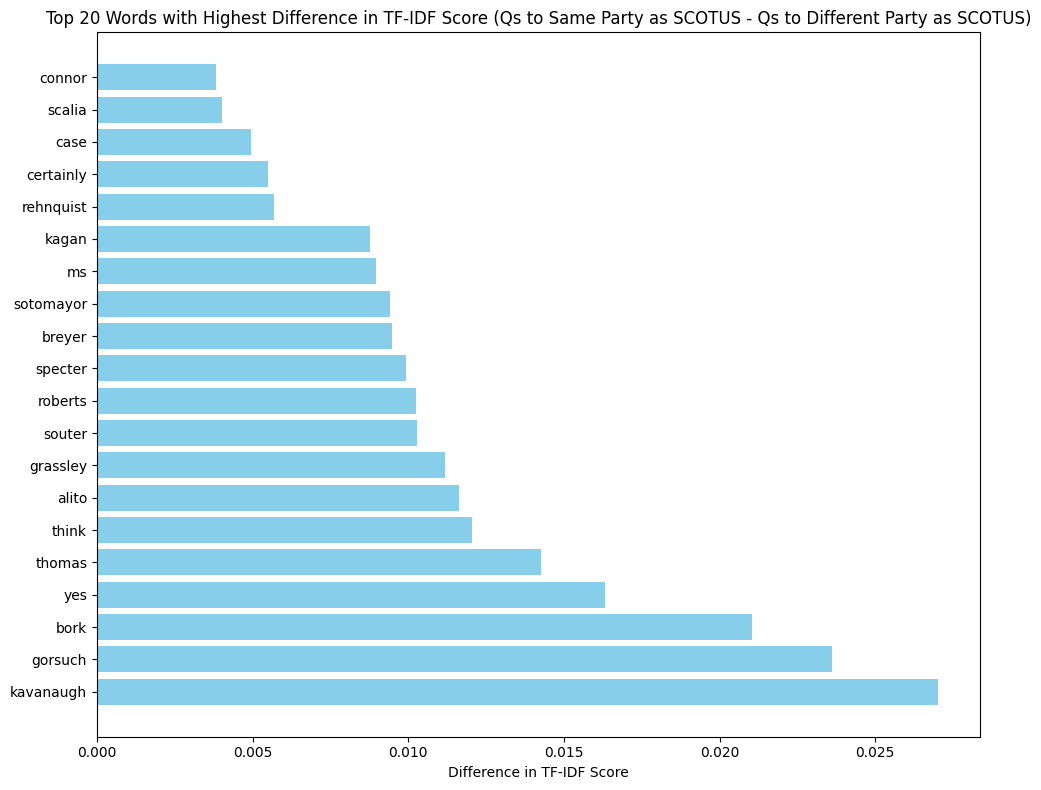

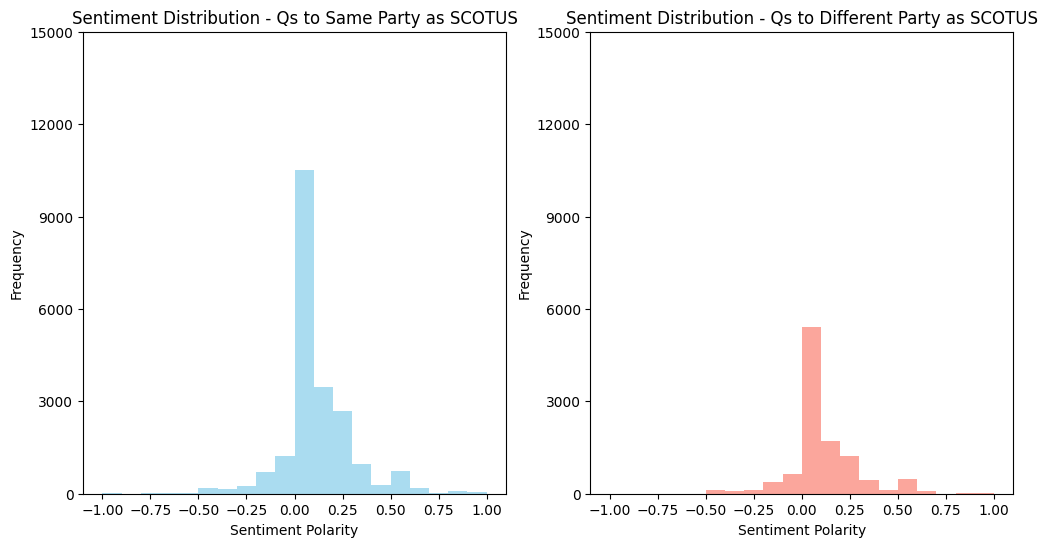

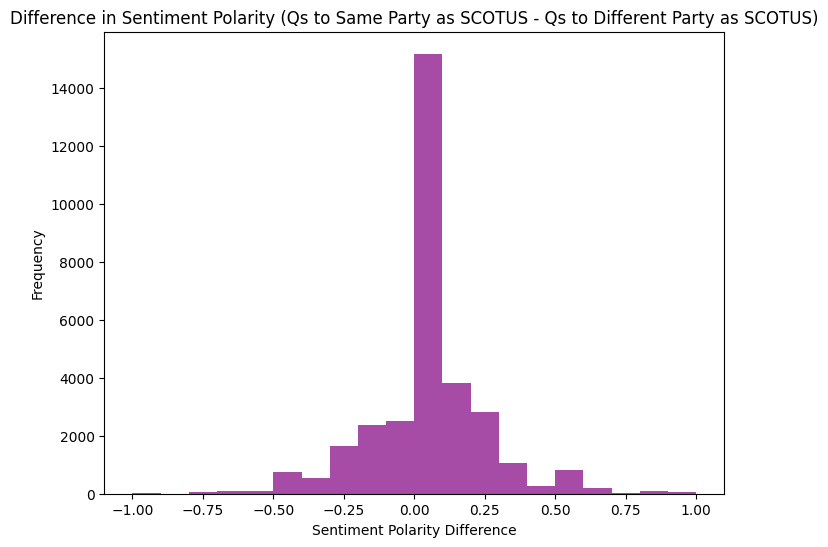

In [12]:
# INVESTIGATE: Questions to same party versus different party
dataset1a = rep_df[rep_df["speaker_party"] == "R"] 
dataset1b = dem_df[dem_df["speaker_party"] == "D"]

dataset1 = pd.concat([dataset1a, dataset1b])

dataset2a = rep_df[rep_df["speaker_party"] == "D"] 
dataset2b = dem_df[dem_df["speaker_party"] == "R"]

dataset2 = pd.concat([dataset2a, dataset2b])

dataset1_label = "Qs to Same Party as SCOTUS"
dataset2_label = "Qs to Different Party as SCOTUS"

# EDA
plot_wordclouds_sentimental(dataset1, dataset2, dataset1_label, dataset2_label)
plot_top_words(dataset1, dataset2, dataset1_label, dataset2_label)
plot_sentiment_analysis(dataset1, dataset2, dataset1_label, dataset2_label)
plot_sentiment_difference(dataset1, dataset2, dataset1_label, dataset2_label)